## K-Means Clustering

### Assignment 1 (2 scores):

- Generate a toy dataset having $600$ data points, $200$ points of them following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma)$, $200$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma)$, and $200$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma)$ where $\Sigma = 
\left(\begin{array}{cc}
    1 & 0 \\
    0 & 1
\end{array}\right)
$.
- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.
- Give comments on the effect of intializing centroids randomly to the overall performance of K-means.

In [17]:
import numpy as np
import matplotlib.pyplot as plt # Only use for data visualization

#### Data Generation

In [18]:
# Set seed for reproducibility
np.random.seed(42)

# Covariance matrix sigma
sigma = np.array([[1, 0], [0, 1]])

# Generate 200 points for each Gaussian distribution
# Cluster 1: Mean (2, 2)
X1 = np.random.multivariate_normal([2, 2], sigma, 200)
# Cluster 2: Mean (8, 3)
X2 = np.random.multivariate_normal([8, 3], sigma, 200)
# Cluster 3: Mean (3, 6)
X3 = np.random.multivariate_normal([3, 6], sigma, 200)

# True labels (for analysis of initialization effect)
y_true = np.concatenate([
    np.zeros(200, dtype=int),
    np.ones(200, dtype=int),
    np.full(200, 2, dtype=int)
])


# Combine all points into a single dataset X
X = np.concatenate([X1, X2, X3], axis=0)
print(f"X shape: {X.shape}")


X shape: (600, 2)


#### Data Visualization

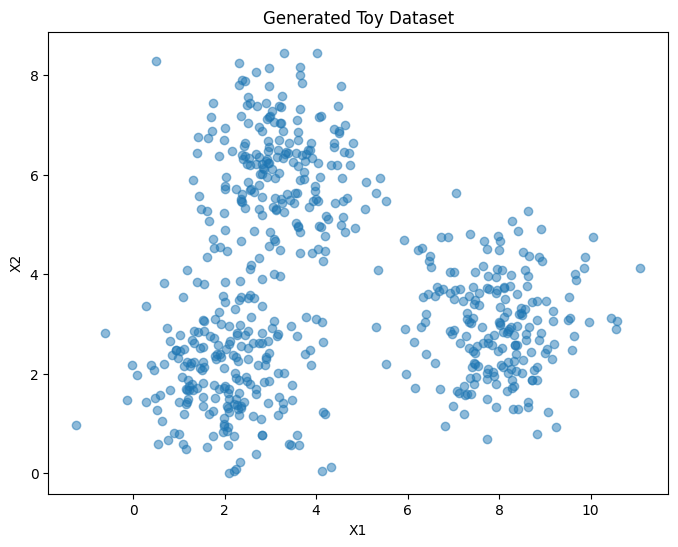

In [19]:
# Visualize the generated data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.title("Generated Toy Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

#### K-Means Implements

In [20]:
def compute_inertia(X, centroids, labels):
    # Sum of squared distances to assigned centroid
    return np.sum((X - centroids[labels])**2)

def hard_em_objective(X, centroids, labels, sigma2=1.0):
    """
    Nếu coi K-means là hard-EM của Gaussian mixture có covariance = sigma2*I,
    thì negative log-likelihood (bỏ hằng số) ~ (1/(2*sigma2))*sum ||x - mu_z||^2
    => tương đương inertia (nhân hằng số).
    """
    return (1.0/(2.0*sigma2)) * compute_inertia(X, centroids, labels)


In [21]:
def kmeans(X, k, max_iters=100, tol=1e-4, seed=None, return_history=False):
    n_samples, n_features = X.shape
    
    if seed is not None:
        np.random.seed(seed)

    # Step 1: Initialize centroids randomly from the data points
    random_indices = np.random.choice(n_samples, k, replace=False)
    centroids = X[random_indices].copy()
    
    labels = np.zeros(n_samples, dtype=int)
    history = {
        "inertia": [],
        "shift": []
    }
    
    for i in range(max_iters):
        # ---------- E-step ----------
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        # ---------- M-step ----------
        new_centroids = np.zeros((k, n_features))
        for j in range(k):
            points_j = X[labels == j]
            if len(points_j) > 0:
                new_centroids[j] = np.mean(points_j, axis=0)
            else:
                # Empty cluster -> re-init to a random point (better than keeping old forever)
                new_centroids[j] = X[np.random.randint(0, n_samples)]
        
        shift = np.linalg.norm(new_centroids - centroids)
        centroids = new_centroids
        
        inertia = compute_inertia(X, centroids, labels)
        history["inertia"].append(inertia)
        history["shift"].append(shift)
        
        # convergence
        if shift < tol:
            # print(f"Converged at iteration {i}")
            break
    
    if return_history:
        return centroids, labels, history
    return centroids, labels


#### Train this K-means with EM method

Final inertia: 1121.8444772936862
Iterations: 5


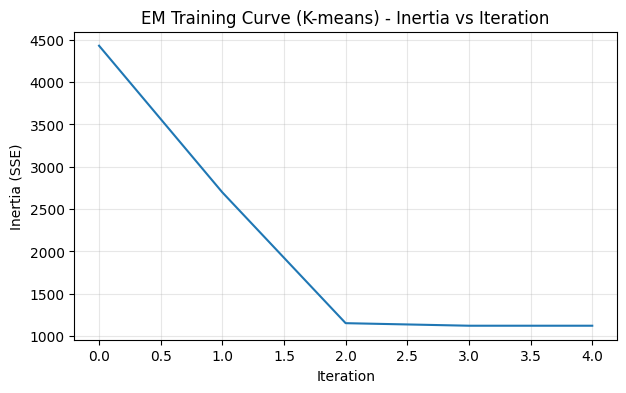

In [22]:
k = 3
centroids, labels, hist = kmeans(X, k, seed=42, return_history=True)

print("Final inertia:", hist["inertia"][-1])
print("Iterations:", len(hist["inertia"]))

plt.figure(figsize=(7,4))
plt.plot(hist["inertia"])
plt.title("EM Training Curve (K-means) - Inertia vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Inertia (SSE)")
plt.grid(True, alpha=0.3)
plt.show()


#### Evaluate the effect of random initialization on the performance of K-means

=== Best init (lowest inertia) ===
seed: 3 inertia: 1121.8444772936862 iters: 5 acc: 0.985
centroids:
 [[3.19050849 6.10167164]
 [7.93924027 2.98407134]
 [2.02113913 2.01991804]]

=== Worst init (highest inertia) ===
seed: 12 inertia: 2785.817293749911 iters: 6 acc: 0.5216666666666666
centroids:
 [[2.59430794 4.06702993]
 [7.64723595 2.03549832]
 [8.10504114 3.69215212]]


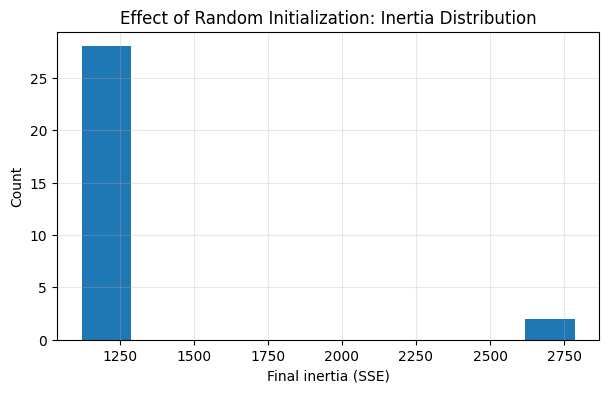

In [23]:
def best_map_accuracy(y_true, y_pred, k=3):
    # map predicted cluster ids to true labels by trying all permutations (k=3 -> 6 perms)
    import itertools
    best_acc = 0.0
    best_perm = None
    for perm in itertools.permutations(range(k)):
        mapped = np.array([perm[c] for c in y_pred])
        acc = np.mean(mapped == y_true)
        if acc > best_acc:
            best_acc = acc
            best_perm = perm
    return best_acc, best_perm

runs = 30
results = []

for s in range(runs):
    C, lab, hist = kmeans(X, 3, seed=s, return_history=True)
    inertia = hist["inertia"][-1]
    iters = len(hist["inertia"])
    acc, perm = best_map_accuracy(y_true, lab, k=3)
    results.append((s, inertia, iters, acc, C))

# sort by inertia
results_sorted = sorted(results, key=lambda x: x[1])

best = results_sorted[0]
worst = results_sorted[-1]

print("=== Best init (lowest inertia) ===")
print("seed:", best[0], "inertia:", best[1], "iters:", best[2], "acc:", best[3])
print("centroids:\n", best[4])

print("\n=== Worst init (highest inertia) ===")
print("seed:", worst[0], "inertia:", worst[1], "iters:", worst[2], "acc:", worst[3])
print("centroids:\n", worst[4])

# Plot inertia distribution
plt.figure(figsize=(7,4))
plt.hist([r[1] for r in results], bins=10)
plt.title("Effect of Random Initialization: Inertia Distribution")
plt.xlabel("Final inertia (SSE)")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()


#### Visualization of Results

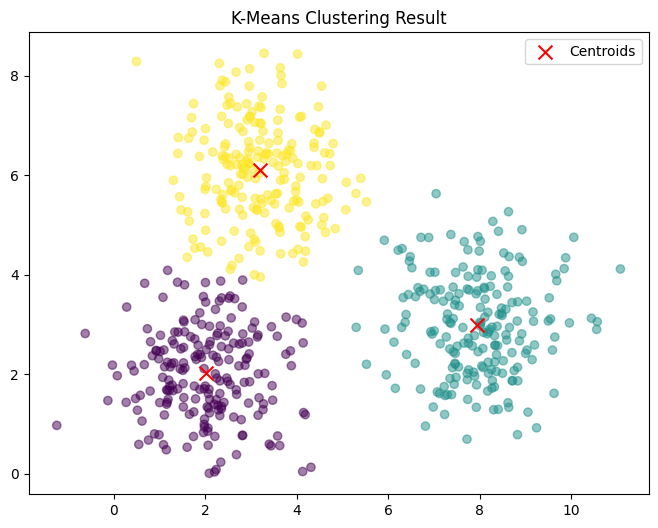

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title("K-Means Clustering Result")
plt.legend()
plt.show()

### Effect of Random Initialization

Initialization plays a crucial role in the performance of K-Means:

1.  **Convergence Speed**: Good initialization can lead to faster convergence (fewer iterations).
2.  **Local Optima**: K-Means tries to minimize the Within-Cluster Sum of Squares (WCSS), which is a non-convex function. This means the algorithm can get stuck in local optima depending on the starting positions of the centroids. 
    - If centroids are initialized close to each other or within the same true cluster, the algorithm might split a natural cluster and merge others incorrectly.
    - While random initialization is simple, it doesn't guarantee the global optimum.
    - To mitigate this, standard practice (like in `sklearn`) involves running the algorithm multiple times with different seeds and choosing the best result (lowest WCSS), or using smarter initialization methods like K-Means++.

#### Comments on the effect of intializing centroids randomly to the overall performance of K-means.
- K-means khởi tạo các centroid ngẫu nhiên nên kết quả phân cụm phụ thuộc nhiều vào vị trí ban đầu của các centroid.
- Do hàm mục tiêu của K-means là không lồi, thuật toán có thể hội tụ vào các nghiệm cục bộ khác nhau.
- Nếu khởi tạo tốt, centroid nhanh về gần tâm cụm thật và kết quả phân cụm chính xác hơn.
- Nếu khởi tạo kém, K-means có thể hội tụ chậm, phân cụm sai hoặc xuất hiện cụm rỗng.
- Vì vậy, cần chạy K-means nhiều lần với các khởi tạo khác nhau và chọn kết quả tốt nhất.

#### Implement K-Means with Scikit-learn and check the result

Centroids (scikit-learn):
 [[7.93924027 2.98407134]
 [3.19050849 6.10167164]
 [2.02113913 2.01991804]]
Inertia (SSE): 1121.844477293686


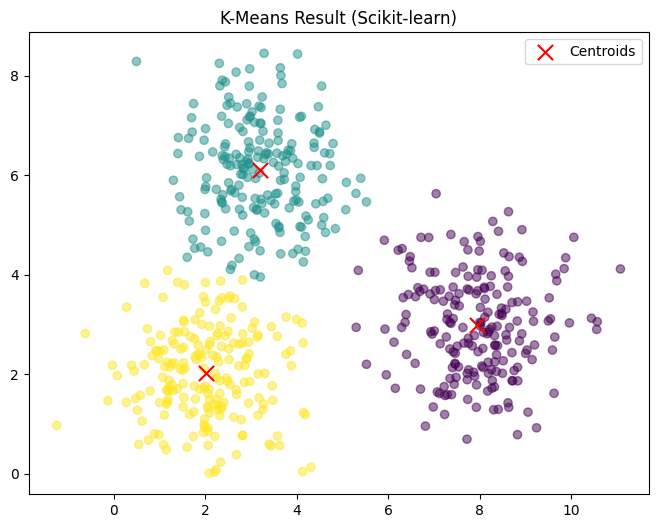

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Use the same dataset X from Assignment 1
k = 3

# Train KMeans (scikit-learn)
kmeans_sklearn = KMeans(n_clusters=k, init="random", n_init=20, random_state=42)
labels_sk = kmeans_sklearn.fit_predict(X)
centroids_sk = kmeans_sklearn.cluster_centers_

print("Centroids (scikit-learn):\n", centroids_sk)
print("Inertia (SSE):", kmeans_sklearn.inertia_)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels_sk, cmap="viridis", alpha=0.5)
plt.scatter(centroids_sk[:, 0], centroids_sk[:, 1], c="red", marker="x", s=120, label="Centroids")
plt.title("K-Means Result (Scikit-learn)")
plt.legend()
plt.show()


### Assignment 2 (2 scores):
- Generate a toy dataset having $50$ points following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma)$, $20$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma)$, and $1000$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma)$ where $\Sigma = 
\left(\begin{array}{cc}
    1 & 0 \\
    0 & 1
\end{array}\right)
$.
- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.
- Give comments on the effect of different sizes among clusters to the performance of K-means.

#### Data Generation

In [26]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

sigma = np.array([[1, 0], [0, 1]])

# Unbalanced clusters
X1 = np.random.multivariate_normal([2, 2], sigma, 50)
X2 = np.random.multivariate_normal([8, 3], sigma, 20)
X3 = np.random.multivariate_normal([3, 6], sigma, 1000)

X = np.concatenate([X1, X2, X3], axis=0)
y_true = np.concatenate([
    np.zeros(50, dtype=int),
    np.ones(20, dtype=int),
    np.full(1000, 2, dtype=int)
])

print("X shape:", X.shape)


X shape: (1070, 2)


Final inertia: 1918.1834852748016 | iters: 14


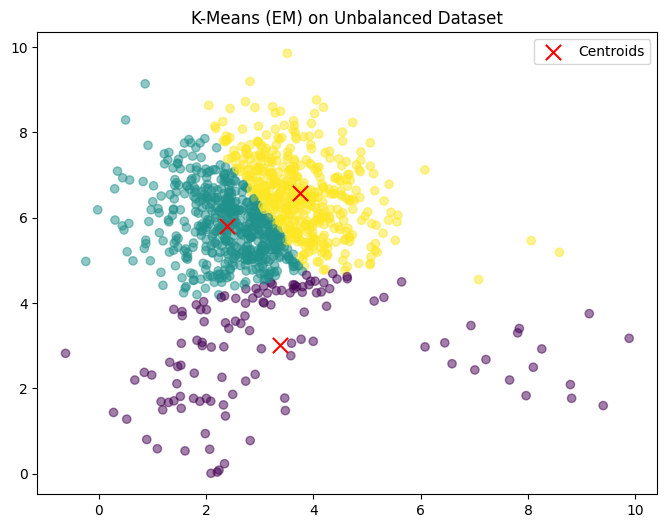

In [27]:
k = 3
centroids, labels, hist = kmeans(X, k, seed=42, return_history=True)

print("Final inertia:", hist["inertia"][-1], "| iters:", len(hist["inertia"]))

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=120, label='Centroids')
plt.title("K-Means (EM) on Unbalanced Dataset")
plt.legend()
plt.show()

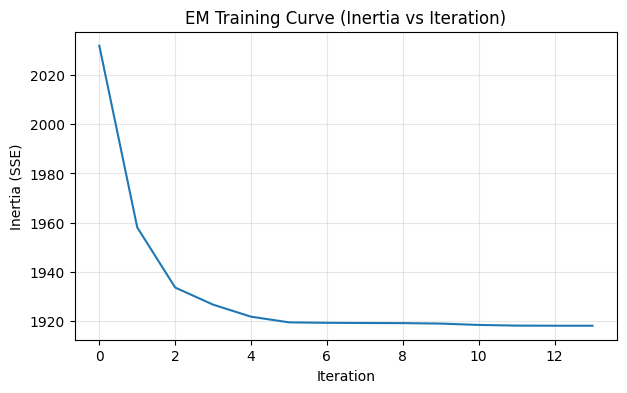

In [28]:
plt.figure(figsize=(7, 4))
plt.plot(hist["inertia"])
plt.title("EM Training Curve (Inertia vs Iteration)")
plt.xlabel("Iteration")
plt.ylabel("Inertia (SSE)")
plt.grid(True, alpha=0.3)
plt.show()

#### Run many times to see how unbalanced data makes K-means fail

Best: (8, np.float64(1846.3968177189606), 39, np.float64(0.5897196261682243))
Worst: (20, np.float64(1921.0772246669212), 14, np.float64(0.4897196261682243))


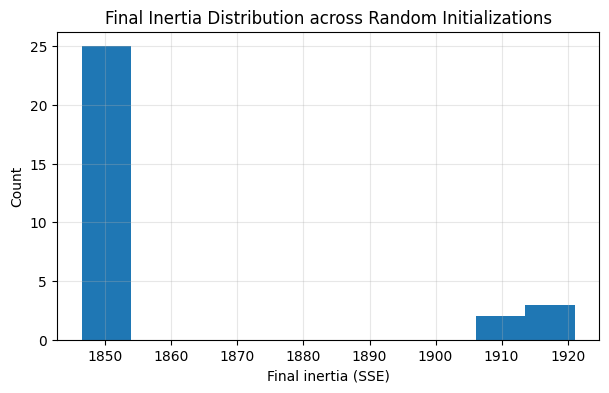

In [29]:
def best_map_accuracy(y_true, y_pred, k=3):
    import itertools
    best_acc = 0.0
    for perm in itertools.permutations(range(k)):
        mapped = np.array([perm[c] for c in y_pred])
        best_acc = max(best_acc, np.mean(mapped == y_true))
    return best_acc

runs = 30
res = []
for s in range(runs):
    C, lab, hist = kmeans(X, 3, seed=s, return_history=True)
    res.append((s, hist["inertia"][-1], len(hist["inertia"]), best_map_accuracy(y_true, lab)))

res_sorted = sorted(res, key=lambda t: t[1])
print("Best:", res_sorted[0])
print("Worst:", res_sorted[-1])

plt.figure(figsize=(7,4))
plt.hist([r[1] for r in res], bins=10)
plt.title("Final Inertia Distribution across Random Initializations")
plt.xlabel("Final inertia (SSE)")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()


#### The effect of different sizes among clusters to the performance of K-means.
- Khi các cụm có kích thước rất khác nhau, K-means thường bị chi phối bởi cụm lớn vì hàm mục tiêu dựa trên tổng bình phương khoảng cách.
- Cụm lớn có xu hướng “kéo” ranh giới phân cụm về phía mình, làm các cụm nhỏ dễ bị gán nhầm.
- Các cụm nhỏ dễ bị mất centroid hoặc bị gộp vào cụm lớn, đặc biệt khi khởi tạo ngẫu nhiên không tốt.
- Do đó, kết quả K-means kém ổn định hơn và phụ thuộc nhiều vào cách khởi tạo centroid.

#### Double Check with KMeans by Scikit-Learn

Centroids (scikit-learn):
 [[4.06257546 5.48067997]
 [2.04353835 3.38376856]
 [2.59903021 6.57931011]]
Inertia (SSE): 1846.4818872187407


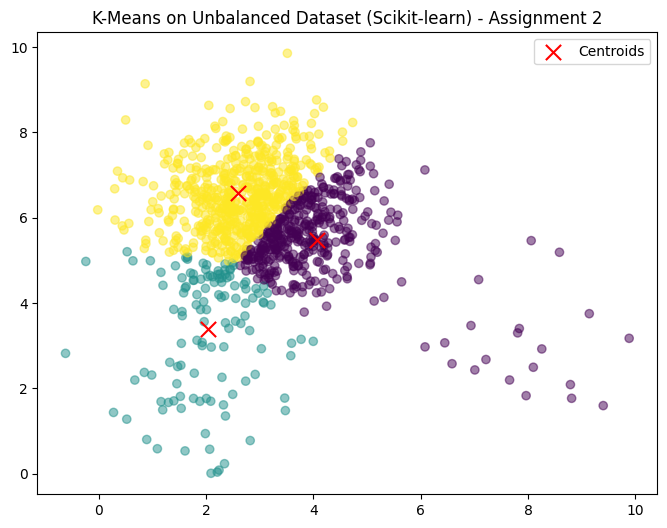

In [30]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Use the same dataset X from Assignment 2
k = 3

# Train KMeans (scikit-learn)
kmeans_sk = KMeans(n_clusters=k, init="random", n_init=20, random_state=42)
labels_sk = kmeans_sk.fit_predict(X)
centroids_sk = kmeans_sk.cluster_centers_

print("Centroids (scikit-learn):\n", centroids_sk)
print("Inertia (SSE):", kmeans_sk.inertia_)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels_sk, cmap="viridis", alpha=0.5)
plt.scatter(centroids_sk[:, 0], centroids_sk[:, 1],
            c="red", marker="x", s=120, label="Centroids")
plt.title("K-Means on Unbalanced Dataset (Scikit-learn) - Assignment 2")
plt.legend()
plt.show()


### Effect of Different Sizes Among Clusters

1.  **Density/Size Bias**: Standard K-Means assumes that clusters are roughly spherical and of similar size/density. It explicitly tries to minimize variance (Euclidean distance to centroids).
2.  **Boundary Shifts**: When one cluster is much largers/denser (like the 1000 points vs 20 points), the centroid of the large cluster is very stable. However, if the clusters are close to each other, the "boundary" (perpendicular bisector) might not optimally separate them based on density. K-means partitions the space purely based on geometric distance.
3.  **In this specific case**: The means $(2,2)$, $(8,3)$, and $(3,6)$ are relatively well-separated compared to their unit variance. So, even with the imbalance, K-Means likely identifies them correctly. However, if they were closer, the massive cluster (1000 points) could "pull" a centroid towards itself or split into two if K=3 forced it, potentially leaving the 20-point cluster merged with another or treated as outliers.

### Assignment 3 (2 scores):

- Generate a toy dataset having $600$ data points, $200$ points of them following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma_1)$, $200$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma_1)$, and $200$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma_2)$ where 

$$
    \Sigma_1 = 
    \left(\begin{array}{cc}
        1 & 0 \\
        0 & 1
    \end{array}\right)
$$ 

and

$$
\Sigma_2 = 
    \left(\begin{array}{cc}
        10 & 0 \\
        0 & 1
    \end{array}\right)
$$.

- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.
- Give comments on the effect of distribution $\mathcal{N}((3, 6), \Sigma_2)$ to the performance of K-means.

X shape: (600, 2)


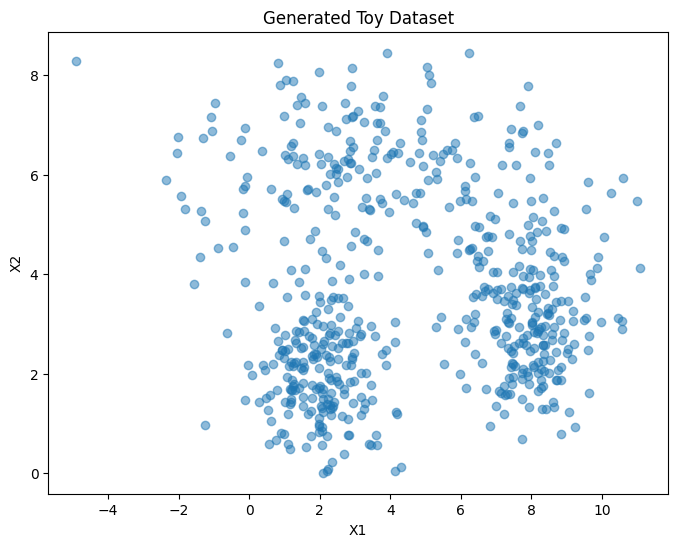

In [31]:
# Set seed
np.random.seed(42)

# Covariance matrices
sigma1 = np.array([[1, 0], [0, 1]])
sigma2 = np.array([[10, 0], [0, 1]])

# Generate data
X1 = np.random.multivariate_normal([2, 2], sigma1, 200)
X2 = np.random.multivariate_normal([8, 3], sigma1, 200)
X3 = np.random.multivariate_normal([3, 6], sigma2, 200)

X = np.concatenate([X1, X2, X3], axis=0)
print("X shape:", X.shape)

# Visualize data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.title("Generated Toy Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [32]:
# Train K-means (EM)
k = 3
centroids, labels = kmeans(X, k)

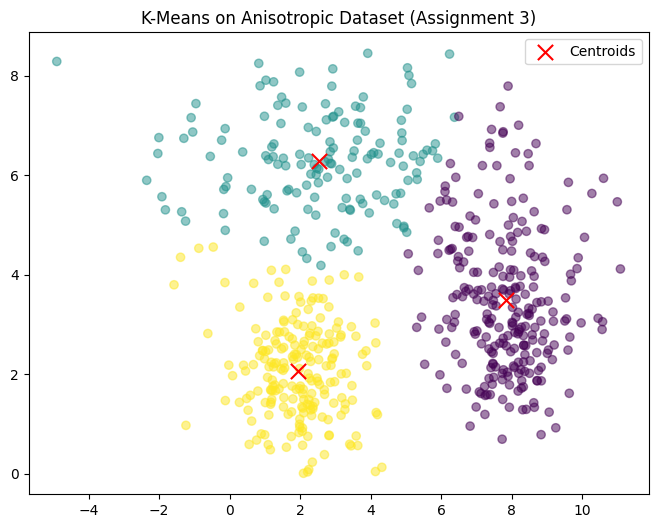

In [33]:
# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1],
            c="red", marker="x", s=120, label="Centroids")
plt.title("K-Means on Anisotropic Dataset (Assignment 3)")
plt.legend()
plt.show()


### Effect of Distribution $\mathcal{N}((3, 6), \Sigma_2)$ to the Performance of K-means

1.  **Spherical Assumption**: K-Means uses Euclidean distance, which implicitly assumes that clusters are spherical (isotropic) and have similar variances. It creates "Voronoi cells" with linear boundaries perpendicular to the lines connecting centroids.
2.  **Anisotropic Failure**: The cluster with $\Sigma_2 = diag(10, 1)$ is stretched horizontally (elliptical). Data points far to the left or right of the mean $(3, 6)$ are still part of this cluster probabilistically.
3.  **Result**: K-Means will likely fail to correctly cluster all points of the stretched distribution. 
    - Points at the far ends of the ellipse might be closer (Euclidean distance) to the centroid of another nearby cluster (like the one at $(2, 2)$ or $(8, 3)$) than to their own centroid.
    - Alternatively, K-Means might split the long cluster into two to minimize the sum of squared errors, while merging other spherical clusters.
4.  **Solution**: This limitation suggests the need for algorithms that can model covariance (like Gaussian Mixture Models - GMM) or density-based clustering (like DBSCAN).

#### Give comments on the effect of distribution $\mathcal{N}((3, 6), \Sigma_2)$ to the performance of K-means.
- Phân phối 𝒩((3,6), Σ₂) có phương sai lớn theo trục x nên dữ liệu bị kéo dài (anisotropic), không còn dạng gần tròn.
- K-means sử dụng khoảng cách Euclid nên giả định các cụm có dạng tròn và phương sai tương tự nhau.
- Do đó, với cụm anisotropic, K-means khó mô hình hóa đúng hình dạng của cụm và dễ phân chia sai ranh giới.
- Centroid của cụm này có thể bị lệch và ảnh hưởng đến việc gán điểm của các cụm khác.
- Kết quả là chất lượng phân cụm giảm và độ ổn định của K-means kém hơn so với trường hợp các cụm có covariance giống nhau.


#### Double Check with KMeans by Scikit-Learn

Centroids (scikit-learn):
 [[7.82773082 3.52419383]
 [2.44220016 6.25733703]
 [1.96713809 2.05011551]]
Inertia (SSE): 1985.3231224504652


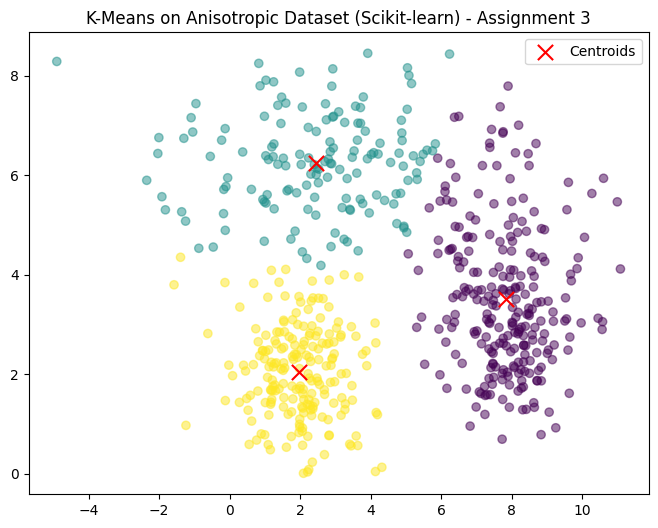

In [34]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Use the same dataset X from Assignment 3
k = 3

# Train KMeans (scikit-learn)
kmeans_sk = KMeans(n_clusters=k, init="random", n_init=20, random_state=42)
labels_sk = kmeans_sk.fit_predict(X)
centroids_sk = kmeans_sk.cluster_centers_

print("Centroids (scikit-learn):\n", centroids_sk)
print("Inertia (SSE):", kmeans_sk.inertia_)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels_sk, cmap="viridis", alpha=0.5)
plt.scatter(centroids_sk[:, 0], centroids_sk[:, 1],
            c="red", marker="x", s=120, label="Centroids")
plt.title("K-Means on Anisotropic Dataset (Scikit-learn) - Assignment 3")
plt.legend()
plt.show()


## Gaussian Mixture Model

### Assignment 1 (2 scores):
- Use Numpy only to implement the Gaussian Mixture Model.
- Train Gaussian Mixture Model with EM method.

### Assignment 2 (2 scores):

Use the Gaussian Mixture Model to filter out background of a given image.